In [1]:
!pip install geopandas 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.3 MB 69.4 MB/s 
     |████████████████████████████████| 16.7 MB 46.4 MB/s 


In [2]:
#@title Importing Packages

# Utility
import math as math
import numpy as np
import pandas as pd
import random as rdm
import scipy.io as io
import scipy.stats as stats
from google.colab import drive
import networkx as nx
import geopandas as gpd

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.animation import FuncAnimation
from functools import partial

In [3]:
drive.mount('drive')

pmatRaw = pd.read_csv("https://drive.google.com/uc?export=download&id=18qzQ-2TRETglAGLSXRZekyQqK7QxXUff")
pmat = pmatRaw.copy()
pmat = pmat.set_index('Unnamed: 0')

marlboroughRaw = pd.read_csv("https://drive.google.com/uc?export=download&id=1VUT1wj5diZIMzkSzgYtbVOz_nkj16JAD")
marlborough = marlboroughRaw.copy()

islandsRaw = gpd.read_file('/content/drive/My Drive/VUW Work/2022/T3 2022/Summer Research Scholarship/Datasets/nz-coastlines-and-islands-polygons-topo-1500k.shx')
islands = islandsRaw.copy()

Mounted at drive


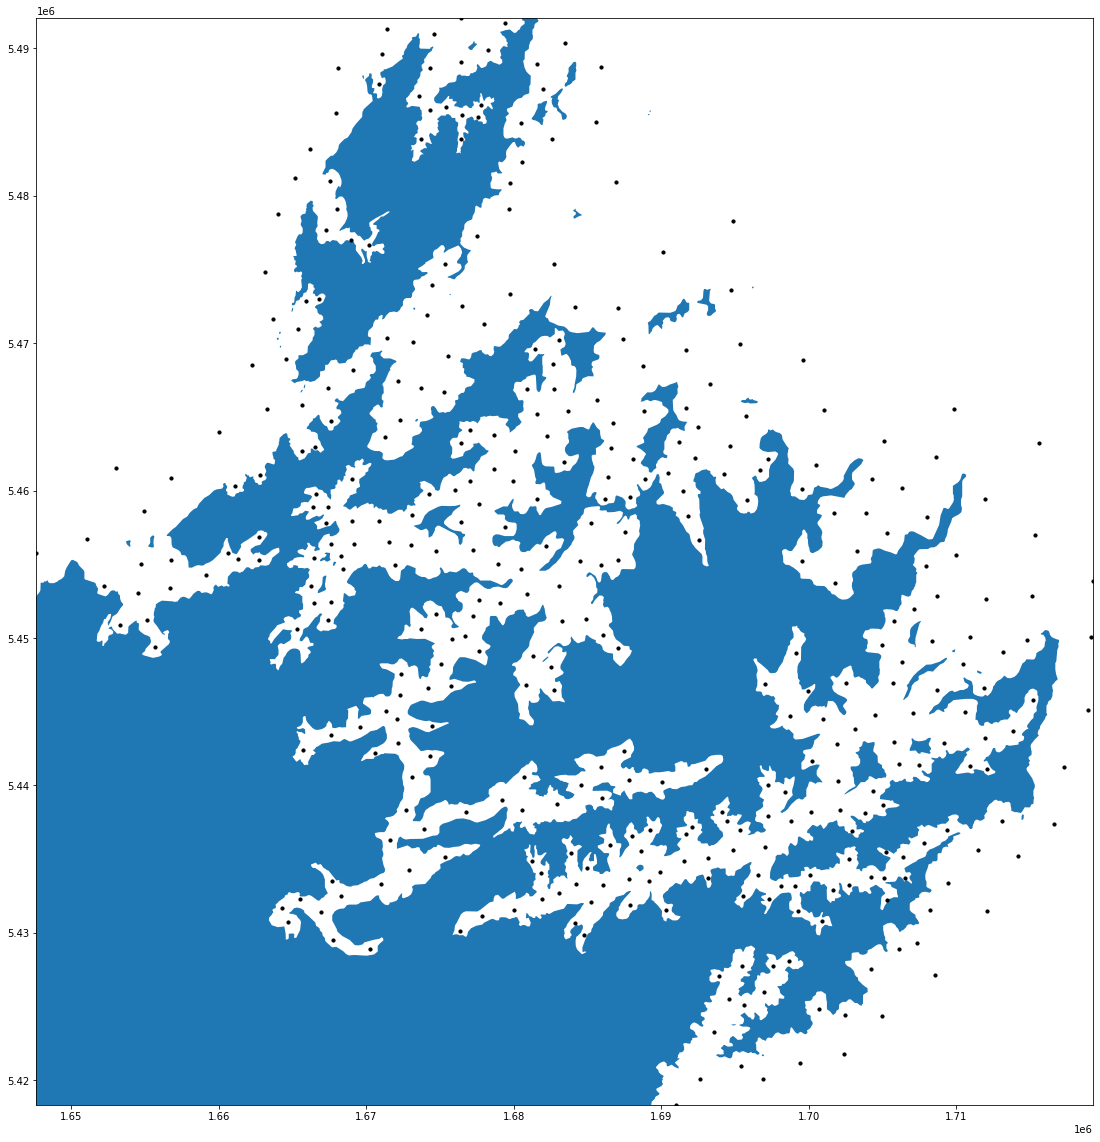

In [4]:
fig, ax = plt.subplots(figsize = (20, 20))

islands['geometry'].plot(ax = ax)
ax.scatter(marlborough.iloc[:, 0], marlborough.iloc[:, 1], s = 10, c = 'k')

ax.set_xlim(min(marlborough.iloc[:, 0]), max(marlborough.iloc[:, 0]))
ax.set_ylim(min(marlborough.iloc[:, 1]), max(marlborough.iloc[:, 1]))

plt.show()

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


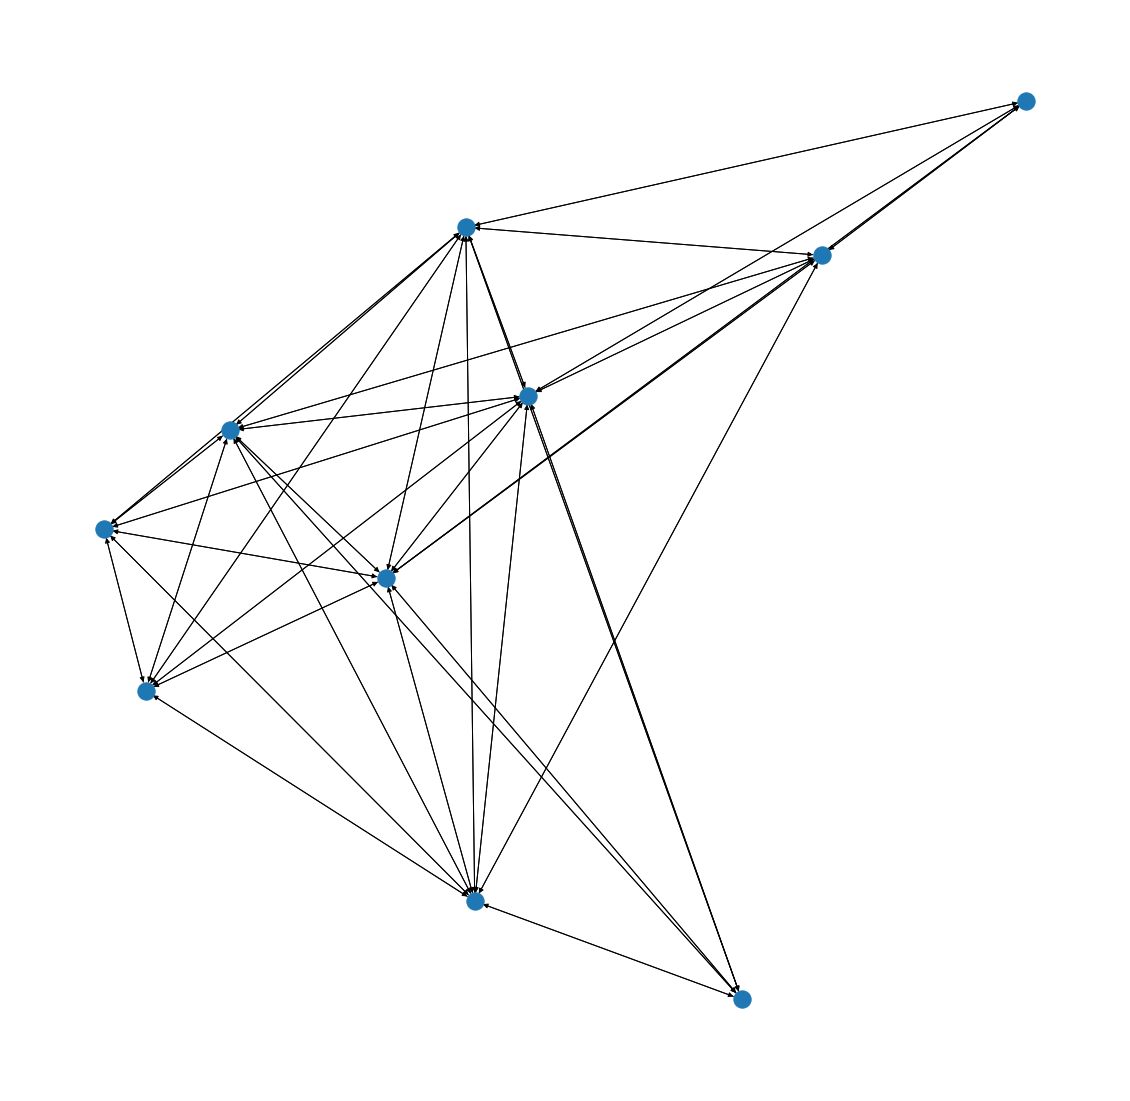

In [5]:
fig, ax = plt.subplots(figsize = (20, 20))

G = nx.DiGraph()
for k in range(10):
  G.add_nodes_from(str(k), pos = (marlborough.iloc[k, 0], marlborough.iloc[k, 1]))

print(G.nodes())

for i in range(10):
    for j in range(10):
        if pmat.iloc[i, j] != 0 and i != j:
          G.add_edge(str(i), str(j))

pos = nx.get_node_attributes(G, 'pos')
ax = nx.draw(G, pos)
plt.show()

In [6]:
G.nodes()

NodeView(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))

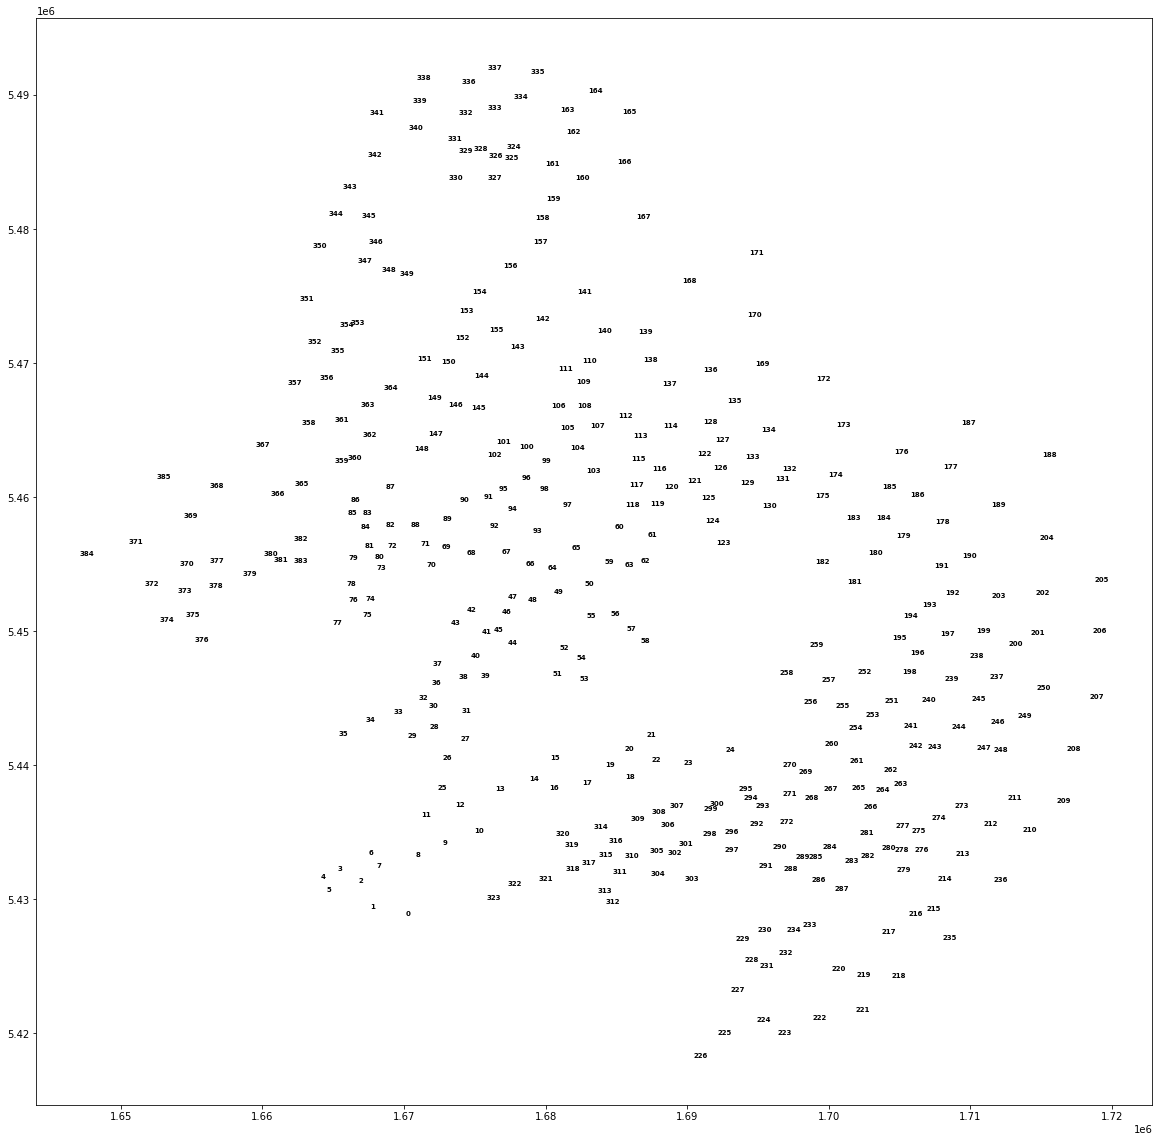

In [7]:
fig, ax = plt.subplots(figsize = (20, 20))
#ax.update_datalims((1640000, 5400000), (1720000, 5500000))


points = ax.scatter(marlborough.iloc[:, 0], marlborough.iloc[:, 1])
for k in range(len(marlborough.index)):
    ax.text(marlborough.iloc[k, 0], marlborough.iloc[k, 1], marlborough.index[k], 
            fontsize = 7, ha = 'center', va = 'center', fontweight = 'bold')
points.set_visible(False)

In [8]:
def findMNew(M, i, t, A, Alpha, Beta, StartBloom, S, pmat):

  start = S*StartBloom
  growth = Alpha*A*M[i]
  transport = Beta*sum(pmat.iloc[i, :]*M)
  MNew = start + growth + transport

  return MNew

In [9]:
def runSimulation(sites, length, pmat):

    Alpha = stats.gamma.rvs(1, 1)
    Beta = stats.beta.rvs(1, 1)

    Alpha = 3
    Beta = 0.5

    N =  int(min(stats.geom.rvs(0.05), length/4))
    A = np.zeros((length, sites))

    for n in range(N):
        i = int(stats.uniform.rvs(0, sites))
        T = int(stats.uniform.rvs(0, length))
        W = int(stats.nbinom.rvs(6, 0.9))

        A[range(T, (min(T + W, length))), i] = 1

    S = np.zeros(sites)
    M = np.zeros(sites)
    MArray = np.zeros((sites, length))

    print(Alpha, Beta)

    for t in range(length):
      for i in range(sites):

        if A[t, i] - A[max(t - 1, 0), i] == 1:
          StartBloom = 1
          print(f"Week {t} - Bloom started at site {i}")
          S[i] = stats.gamma.rvs(1, 1)
        else:
          StartBloom = 0

        M[i] = findMNew(M, i, t, A[t, i], Alpha, Beta, StartBloom, S[i], pmat.iloc[:sites, :sites])
        MArray[i, t] = M[i]

    fig, ax = plt.subplots(2, sharex = True, figsize = (20, 10))
    plt.suptitle(print("Alpha = ", Alpha, ", Beta = ", Beta), x = 0.5, y = 1.05, fontsize = 30)
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.nipy_spectral(np.linspace(0, 1, sites + 1)))
    for i in range(sites):
        ax[0].plot(range(length), MArray[i, :], label = pmat.columns[i])
        ax[1].plot(range(length), np.log(MArray[i, :]), label = pmat.columns[i])
    ax[0].set_title("Intensity of all sites", fontsize = 20)
    ax[0].set_ylabel("Intensity", fontsize = 20)
    ax[1].set_title("Log intensity of all sites", fontsize = 15)
    ax[1].set_ylabel("Intensity - Log", fontsize = 15)
    plt.xlabel("Week", fontsize = 15)

    fig.legend(pmat.columns[:sites])
    plt.tight_layout()
    plt.show()

    return MArray

3 0.5
Week 17 - Bloom started at site 357
Week 37 - Bloom started at site 146
Week 77 - Bloom started at site 176
Week 90 - Bloom started at site 154
Alpha =  3 , Beta =  0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning:

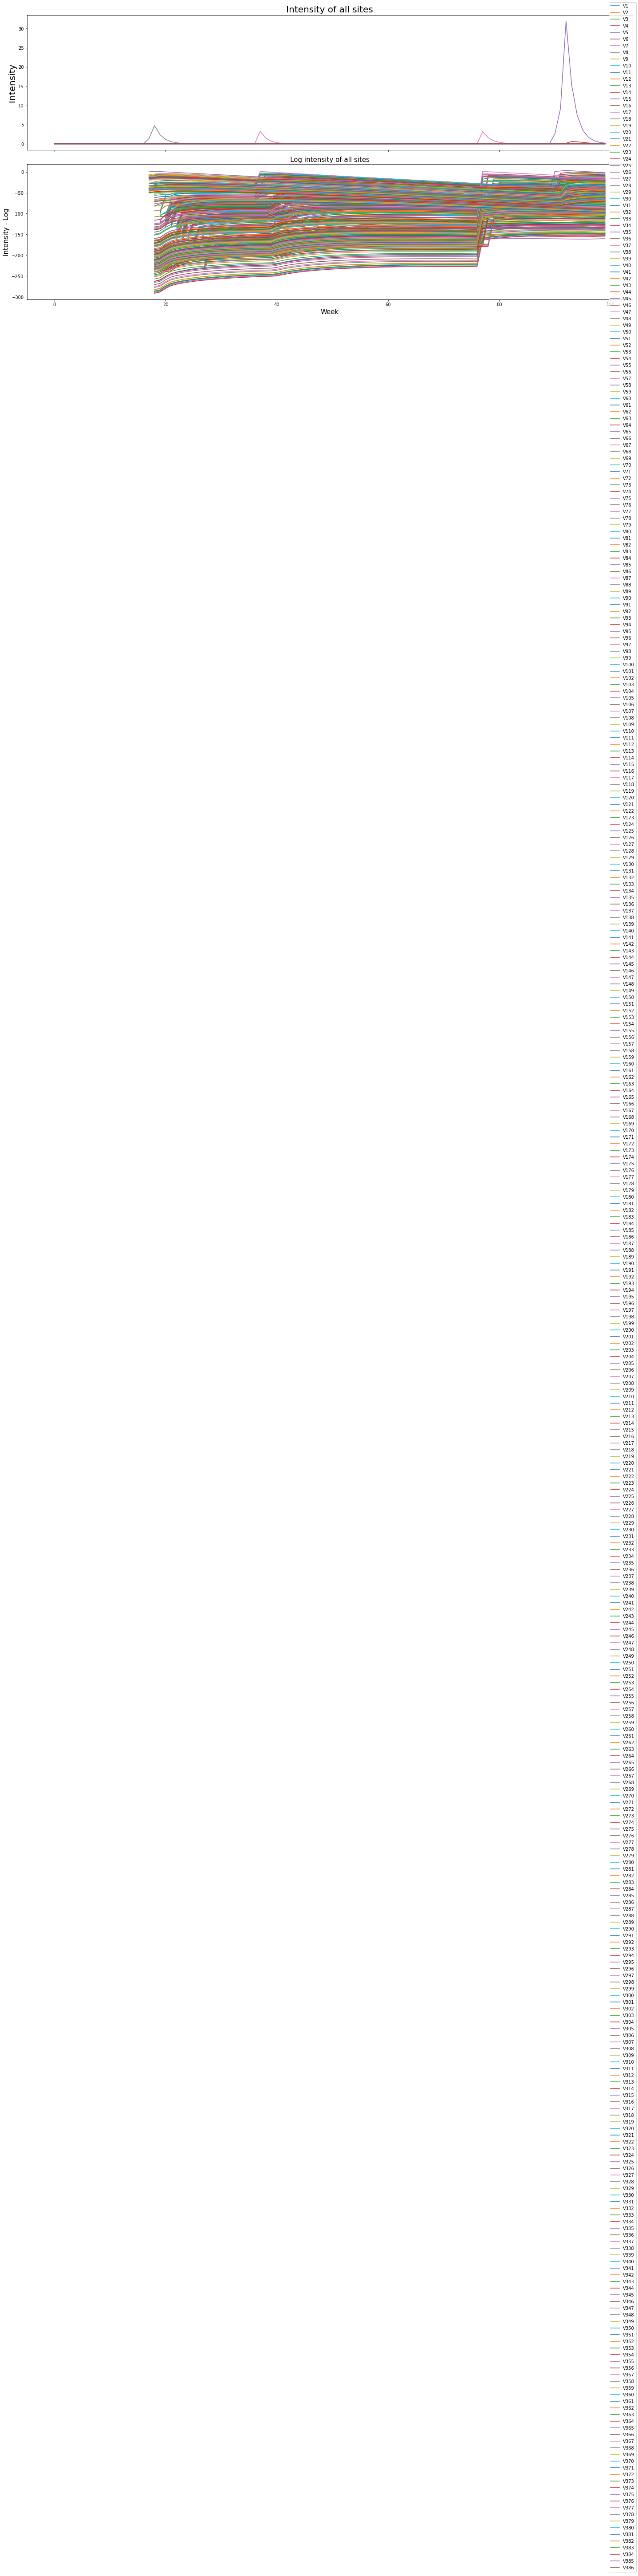

In [11]:
MArray = runSimulation(len(pmat.columns), 100, pmat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


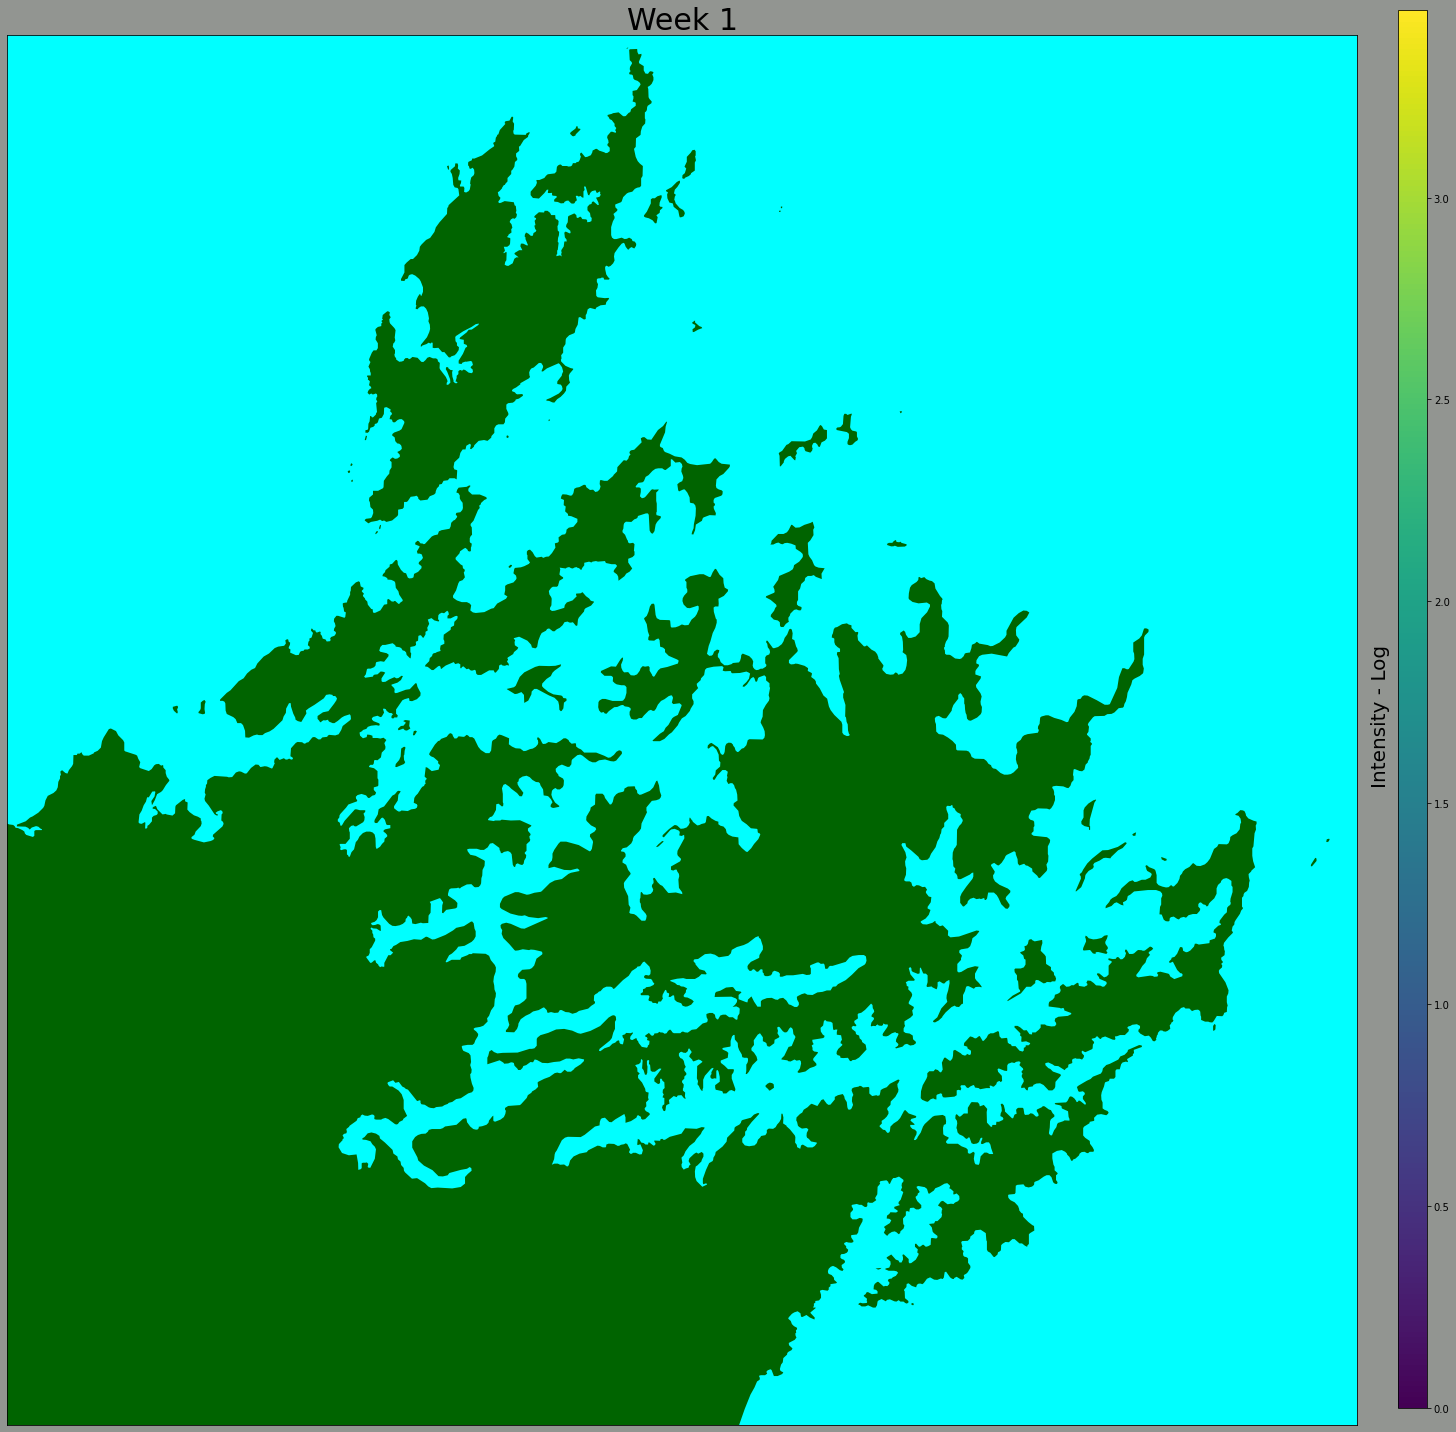

In [42]:
fig, ax = plt.subplots(figsize = (20, 20), facecolor = 'xkcd:grey')
plt.tight_layout()
plt.tick_params(bottom = False, left = False)
plt.rcParams['savefig.bbox'] = 'tight' 
ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])

maxSites = 0
for i in range(len(pmat.columns)):

    maxSite = max(MArray[i, :])
    maxSites = max(maxSites, maxSite)

cmap = plt.cm.viridis
norm = mpl.colors.Normalize(vmin = 0, vmax = np.log(maxSites))

cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), shrink = 0.5, cax = cax)
cbarLab = fig.text(0.985, 0.5, "Intensity - Log", rotation = 90, va = 'center', ha = 'center', fontsize = 20)


islands['geometry'].plot(ax = ax, color = 'darkgreen')

xDiff = max(marlborough.iloc[:, 0]) - min(marlborough.iloc[:, 0])
yDiff = max(marlborough.iloc[:, 1]) - min(marlborough.iloc[:, 1])
ax.set_xlim(min(marlborough.iloc[:, 0]) - 0.05*xDiff, max(marlborough.iloc[:, 0]) + 0.05*xDiff)
ax.set_ylim(min(marlborough.iloc[:, 1]) - 0.05*yDiff, max(marlborough.iloc[:, 1]) + 0.05*yDiff)

points = ax.scatter(marlborough.iloc[:, 0], marlborough.iloc[:, 1], c = cmap(norm(np.log(MArray[:, 0]))), s = 1000*norm(MArray[:, 0]))

#for k in range(sites):
    #ax.text(marlborough.iloc[k, 0], marlborough.iloc[k, 1] - 100, f"V{marlborough.index[k] + 1}", 
            #fontsize = 20, ha = 'center', va = 'center', fontweight = 'bold')


ax.set_title(f"Week 0", fontsize = 30)

def animate(i, MArray, sites, cmap, norm):
    ax.cla()

    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    islands['geometry'].plot(ax = ax, color = 'darkgreen')

    xDiff = max(marlborough.iloc[:, 0]) - min(marlborough.iloc[:, 0])
    yDiff = max(marlborough.iloc[:, 1]) - min(marlborough.iloc[:, 1])
    ax.set_xlim(min(marlborough.iloc[:, 0]) - 0.05*xDiff, max(marlborough.iloc[:, 0]) + 0.05*xDiff)
    ax.set_ylim(min(marlborough.iloc[:, 1]) - 0.05*yDiff, max(marlborough.iloc[:, 1]) + 0.05*yDiff)

    ax.set_title(f"Week {i + 1}", fontsize = 30)

    points = ax.scatter(marlborough.iloc[:sites, 0], marlborough.iloc[:sites, 1], c = cmap(norm(np.log(MArray[:, i]))), s = 1000*norm(MArray[:, i]))

    ax.set_facecolor('aqua')

    return ax

anim = FuncAnimation(
        fig, partial(animate, MArray = MArray, sites = len(pmat.columns), cmap = cmap, norm = norm), interval = 250, frames = 99)

fig.tight_layout()
plt.draw()
plt.show()



In [43]:
from IPython.display import HTML

HTML(anim.to_html5_video())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning:

<Figure size 432x288 with 0 Axes>